# Évaluation des Performances : Maintenance Prédictive

Ce notebook évalue l'impact du *drift* (dérive de température) sur les performances du modèle de prédiction de pannes.
Nous comparerons la performance du modèle sur la **Phase A (Normal)** et la **Phase B (Drift)**.

Nous utiliserons le **Bootstrap** pour construire des intervalles de confiance (IC) autour de l'Accuracy, afin de prouver statistiquement la dégradation.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


## Importation des bibliothèques

Nous utilisons :
- `scikit-learn` pour la construction et l'évaluation du modèle
- `numpy` et `pandas` pour la manipulation des données
- `matplotlib` pour les visualisations

In [13]:
data_A = pd.read_csv("data/phase_A_historical.csv")
data_B = pd.read_csv("data/phase_B_production.csv")

features = ["temperature", "vibration", "pressure", "rpm"]
target = "failure"
 
X_A = data_A[features]
y_A = data_A[target]

X_B = data_B[features]
y_B = data_B[target]

print("Phase A:", X_A.shape)
print("Phase B:", X_B.shape)

Phase A: (2000, 4)
Phase B: (2000, 4)


## Chargement des données

Chargement des datasets des deux phases et séparation des features (variables explicatives) et de la cible (churn).

## Analyse Exploratoire des Données (EDA)

Avant de construire le modèle, nous analysons les relations entre les variables explicatives et la variable cible `failure`.

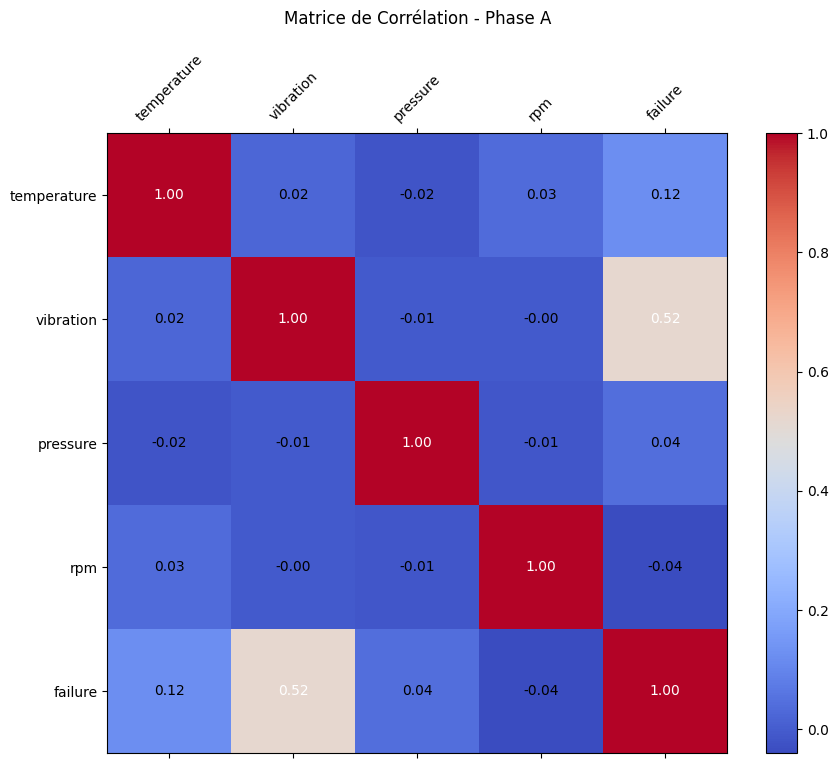

✓ Matrice de corrélation sauvegardée dans images/correlation_matrix_phase_A.png


In [14]:
import matplotlib.pyplot as plt

# Matrice de corrélation
corr_matrix = data_A[features + ["failure"]].corr()

plt.figure(figsize=(10, 8))
# Use matshow
cax = plt.matshow(corr_matrix, cmap='coolwarm', fignum=1)
plt.colorbar(cax)

# Ticks
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Values in cells
for (i, j), val in np.ndenumerate(corr_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black' if abs(val) < 0.5 else 'white')

plt.title("Matrice de Corrélation - Phase A", pad=20)
plt.savefig("images/correlation_matrix_phase_A.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Matrice de corrélation sauvegardée dans images/correlation_matrix_phase_A.png")

### Matrice de Corrélation

Nous analysons les corrélations linéaires entre les variables et la cible (`failure`).
Une forte corrélation (positive ou négative) indique un lien direct.

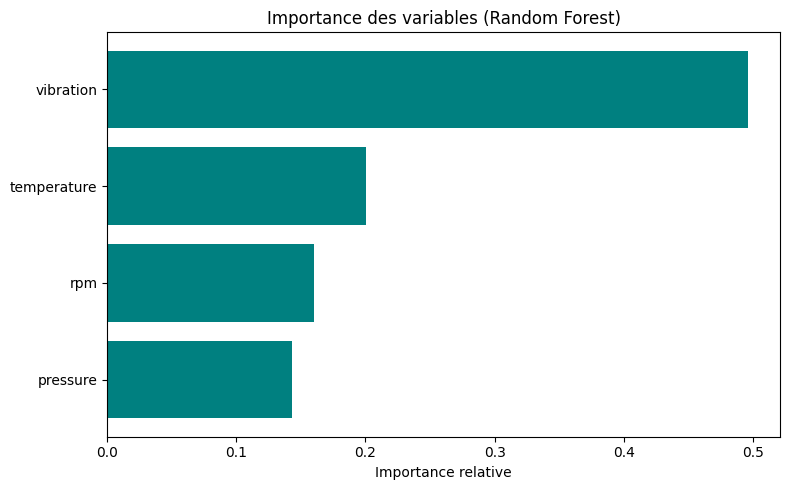

✓ Importance des variables sauvegardée dans images/feature_importance_rf.png


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement d'un Random Forest pour l'importance des variables
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_A, y_A)

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.title("Importance des variables (Random Forest)")
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance relative")
plt.tight_layout()
plt.savefig("images/feature_importance_rf.png", dpi=300)
plt.show()

print("✓ Importance des variables sauvegardée dans images/feature_importance_rf.png")

### Analyse de l'importance des variables

Nous utilisons un Random Forest simple pour estimer l'importance de chaque feature dans la prédiction de la panne.
Cela nous permet de confirmer que nos variables clés (température, vibration) sont bien les plus impactantes avant de lancer la modélisation linéaire.

In [16]:
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])


## Construction du modèle

Nous utilisons un pipeline :
1. **StandardScaler** : Normalisation (indispensable pour la Régression Logistique).
2. **Régression Logistique** : Modèle simple pour prédire la probabilité de panne (`failure`).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_A, y_A, test_size=0.3, random_state=42, stratify=y_A
)

model.fit(X_train, y_train)


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Entraînement du modèle sur la Phase A

Division des données historiques (Phase A) en ensembles d'entraînement (70%) et de test (30%), puis entraînement du modèle. La stratification assure une répartition équilibrée des classes dans les deux ensembles.

In [18]:
y_pred_A = model.predict(X_test)
y_proba_A = model.predict_proba(X_test)[:, 1]

acc_A = accuracy_score(y_test, y_pred_A)
auc_A = roc_auc_score(y_test, y_proba_A)

print(f"Phase A Accuracy : {acc_A:.3f}")
print(f"Phase A AUC      : {auc_A:.3f}")


Phase A Accuracy : 0.928
Phase A AUC      : 0.914


## Évaluation sur la Phase A (données de test)

Calcul des métriques de performance sur l'ensemble de test de la Phase A :
- **Accuracy** : proportion de prédictions correctes
- **AUC-ROC** : capacité du modèle à discriminer entre les classes

Ces métriques servent de baseline pour comparer les performances en production.

In [19]:
y_pred_B = model.predict(X_B)
y_proba_B = model.predict_proba(X_B)[:, 1]

acc_B = accuracy_score(y_B, y_pred_B)
auc_B = roc_auc_score(y_B, y_proba_B)

print(f"Phase B Accuracy : {acc_B:.3f}")
print(f"Phase B AUC      : {auc_B:.3f}")


Phase B Accuracy : 0.874
Phase B AUC      : 0.872


## Évaluation sur la Phase B (données de production)

Application du même modèle (entraîné sur Phase A) aux données de production (Phase B) pour mesurer la dégradation potentielle des performances due au drift.

In [20]:
def bootstrap_metric(X, y, model, metric_fn, n_bootstrap=1000):
    scores = []
    n = len(X)
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        X_sample = X.iloc[idx]
        y_sample = y.iloc[idx]
        
        y_pred = model.predict(X_sample)
        scores.append(metric_fn(y_sample, y_pred))
    
    return np.array(scores)


## Méthode Bootstrap pour l'inférence statistique

Le bootstrap est une technique de rééchantillonnage permettant d'estimer la distribution d'une statistique. Cette fonction génère 1000 échantillons bootstrap et calcule la métrique de performance sur chacun d'eux.

**Principe** : 
- Tirer avec remise n échantillons (n = taille de l'ensemble)
- Calculer la métrique sur cet échantillon
- Répéter 1000 fois pour obtenir une distribution empirique

In [21]:
boot_acc_A = bootstrap_metric(
    X_test, y_test, model, accuracy_score
)


### Application du Bootstrap sur Phase A

Génération de 1000 valeurs d'accuracy via bootstrap pour estimer la variabilité de la performance sur les données de test de Phase A.

In [22]:
boot_acc_B = bootstrap_metric(
    X_B, y_B, model, accuracy_score
)


### Application du Bootstrap sur Phase B

Génération de 1000 valeurs d'accuracy via bootstrap pour estimer la variabilité de la performance sur les données de production (Phase B).

In [23]:
def confidence_interval(scores, alpha=0.05):
    lower = np.percentile(scores, 100 * alpha / 2)
    upper = np.percentile(scores, 100 * (1 - alpha / 2))
    return lower, upper

ci_A = confidence_interval(boot_acc_A)
ci_B = confidence_interval(boot_acc_B)

print(f"IC 95% Accuracy Phase A : {ci_A}")
print(f"IC 95% Accuracy Phase B : {ci_B}")


IC 95% Accuracy Phase A : (np.float64(0.9083333333333333), np.float64(0.9483333333333334))
IC 95% Accuracy Phase B : (np.float64(0.8585), np.float64(0.8875))


## Construction des intervalles de confiance à 95%

Les intervalles de confiance sont calculés à partir des distributions bootstrap en utilisant les percentiles 2.5% et 97.5%. 

**Interprétation** : Nous avons 95% de confiance que la vraie valeur de l'accuracy se situe dans cet intervalle.

/tmp/ipykernel_6877/1687645724.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([boot_acc_A, boot_acc_B], labels=['Phase A', 'Phase B'], patch_artist=True,


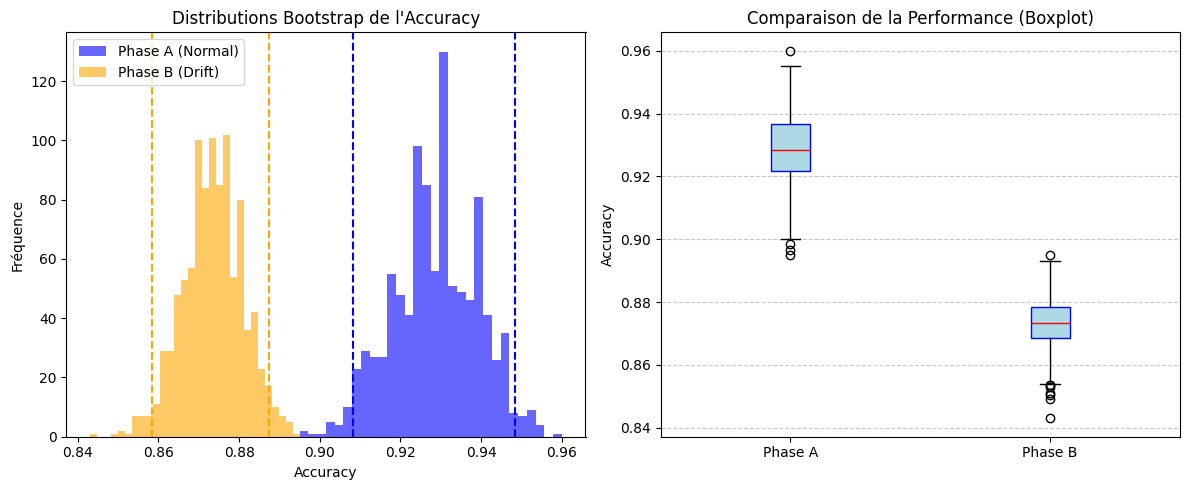

✓ Figure sauvegardée dans images/model_performance_comparison.png


In [24]:
plt.figure(figsize=(12, 5))

# Plot 1: Histogrammes des distributions bootstrap
plt.subplot(1, 2, 1)
plt.hist(boot_acc_A, bins=30, alpha=0.6, label="Phase A (Normal)", color='blue')
plt.hist(boot_acc_B, bins=30, alpha=0.6, label="Phase B (Drift)", color='orange')
plt.axvline(ci_A[0], linestyle="--", color='blue')
plt.axvline(ci_A[1], linestyle="--", color='blue')
plt.axvline(ci_B[0], linestyle="--", color='orange')
plt.axvline(ci_B[1], linestyle="--", color='orange')
plt.legend()
plt.title("Distributions Bootstrap de l'Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Fréquence")

# Plot 2: Boxplot pour comparaison directe
plt.subplot(1, 2, 2)
plt.boxplot([boot_acc_A, boot_acc_B], labels=['Phase A', 'Phase B'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))
plt.title("Comparaison de la Performance (Boxplot)")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("images/model_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure sauvegardée dans images/model_performance_comparison.png")

## Visualisation des distributions bootstrap

Comparaison graphique des distributions d'accuracy obtenues par bootstrap pour les deux phases. Les lignes verticales en pointillés représentent les bornes des intervalles de confiance à 95%.

In [25]:
overlap = not (ci_A[1] < ci_B[0] or ci_B[1] < ci_A[0])

if overlap:
    print("Les IC se chevauchent : dégradation non concluante statistiquement.")
else:
    print("Les IC ne se chevauchent pas : dégradation significative de la performance.")


Les IC ne se chevauchent pas : dégradation significative de la performance.


## Test de chevauchement des intervalles de confiance

**Méthode** : Si les intervalles de confiance ne se chevauchent pas, cela indique une différence statistiquement significative entre les performances des deux phases.

**Critère** :
- Chevauchement : la différence n'est pas statistiquement significative au seuil de 95%
- Pas de chevauchement : dégradation (ou amélioration) significative de la performance

## Conclusion

Cette analyse bootstrap permet de quantifier avec rigueur statistique l'impact du drift sur les performances du modèle. 

**Points clés** :
- Le bootstrap fournit une estimation de la distribution des métriques sans hypothèse paramétrique
- Les intervalles de confiance permettent de tester la significativité des différences observées
- Cette approche est complémentaire au test de Kolmogorov-Smirnov qui détecte le drift sur les features

**Recommandations** :
- Si dégradation significative : réentraîner le modèle avec les nouvelles données
- Si pas de dégradation malgré le drift : le modèle reste robuste, mais surveillance continue nécessaire
- Documenter les seuils d'alerte pour déclencher un réentraînement automatique